## Data Aggregation

Hyperspectral data sets are high-dimensional and can contain a large number of spectral bands. This makes it challenging to analyze them efficiently and accurately. One common approach to addressing this issue is **data aggregation**, which involves reducing the number of spectral bands while retaining the essential information present in the data.

Data aggregation methods involve grouping adjacent bands or applying mathematical functions to combine bands, resulting in fewer but broader bands. These methods can reduce the data size, making it more manageable for processing and analysis, while also preserving important features and reducing noise.

Data aggregation can also improve the performance of machine learning algorithms, as it reduces the complexity of the data and allows for better feature selection. In this guide, we will cover various data aggregation techniques and their applications in hyperspectral data analysis, providing practical examples and implementation guidelines to help you effectively reduce dimensionality and improve the accuracy of your results.

The presented notebook includes a code that showcases the utilization of data aggregation by computing the mean of multiple columns to produce a single value. The code is developed to determine the optimal number of columns to average, ensuring the highest performance on the test set.

In [15]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import expon, reciprocal
from tqdm import tqdm
import matplotlib.pyplot as plt
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [10]:
def load_data(csv_path, feature_col_start, feature_col_end, target_col):
    """
    Load a CSV file into a Pandas DataFrame,drop Nan, and separate the feature and target columns.

    Parameters:
        csv_path (str): Path to the CSV file to load.
        feature_col_start, feature_col_end, (ints): Range of column indices to use as features.
        target_col (str or int): Name or index of the column to use as target.

    Returns:
        new_df: A df containing the features + labels DataFrame.
    """
    # Load CSV into a Pandas DataFrame
    df = pd.read_csv(csv_path)

    # drop nan
    df = df.dropna()

    # Extract the feature and target columns
    new_df = df[df.columns[feature_col_start: feature_col_end]]
    new_df[target_col] = df[target_col]

    return new_df

In [16]:
def svr_regression(df, target_column, split_ratio,N):
    """
    df : Pandas DataFrame, the dataset to be used for the regression
    target_column : str, the name of the column that represents the target variable
    split_ratio : float, the ratio in which the dataset will be split into training and testing sets
    N: int, the number of columns to aggregte

    returns : int, int, the indices of the minimum RMSE and maximum R2 scores, respectively
    """
    # define x,y
    X, y = df.drop(target_column, axis=1), df[target_column]

    # Define range of values for N
    N = range(1, N)

    # Create empty lists to store R2 and RMSE values for each N
    r2_values = []
    rmse_values = []

    # Loop over each value of N with tqdm progress bar
    for n in tqdm(N):

        # create a new dataframe containing the mean of each group of n columns
        sub_data = X.groupby(np.arange(len(X.columns)) // n, axis=1).mean()

        # create a list of new column names
        new_cols = [f'{col}_mean' for col in X.columns[::n]]

        # rename the columns of sub_data
        sub_data.columns = new_cols

        # Split to train/test
        X_train, X_test, y_train, y_test = train_test_split(sub_data, y, test_size=split_ratio, random_state=42)

        # Create an SVR model and fit it to the training data
        param_distribs = {
            'kernel': ['rbf', 'linear'],
            'shrinking': [False, True],
            'C': reciprocal(10, 200),
            'epsilon': reciprocal(0.1, 1.0),
            'coef0': expon(scale=1.0),
            'gamma': expon(scale=1.0),
            'degree': [1, 2, 3, 4, 5, 6],
            'tol': expon(scale=1e-4)
        }

        svm_reg = SVR()
        rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                        n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                        verbose=0, random_state=42)
        rnd_search.fit(X_train, y_train)

        # Use cross-validation to predict the target variable for the training set
        y_train_pred = rnd_search.predict(X_train)

        # Calculate the R2 and RMSE values and store them in the lists
        r2_values.append(r2_score(y_train, y_train_pred))
        rmse_values.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))

    # Find the index of minimum RMSE and maximum R2
    min_rmse_idx = np.argmin(rmse_values)
    max_r2_idx = np.argmax(r2_values)

    return r2_values,rmse_values,min_rmse_idx, max_r2_idx


## Example

In [12]:
# Define input parameters
csv_path = '/content/data.csv'
feature_idx_i,feature_idx_f = 16,-2 # columns index of features
target_col = 'A' # labael column (regression)
split_ratio=0.3
N=15

In [13]:
# Load data
data = load_data(csv_path, feature_idx_i,feature_idx_f, target_col)
data.head()

<ipython-input-10-629dbe82679f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[target_col] = df[target_col]


,TleafCnd,397.32,400.2,403.09,405.97,408.85,411.74,414.63,417.52,420.4,...,978.88,981.96,985.05,988.13,991.22,994.31,997.4,1000.49,1003.58,A
0,24.688274,0.179808,0.152106,0.129191,0.115715,0.107613,0.102074,0.101501,0.099727,0.096248,...,0.458213,0.464172,0.458520,0.462214,0.467727,0.467549,0.466043,0.471523,0.447471,2.017270
1,24.719270,0.221156,0.186298,0.160032,0.146194,0.136323,0.128331,0.124891,0.121850,0.116359,...,0.717970,0.717748,0.722268,0.726763,0.738159,0.741649,0.739217,0.762054,0.622104,1.872474
2,24.543110,0.221893,0.185626,0.164002,0.154074,0.146511,0.137888,0.133002,0.130920,0.128935,...,0.670528,0.675308,0.669332,0.689363,0.685825,0.698885,0.689815,0.705207,0.580815,2.043818
3,24.575045,0.162126,0.129779,0.104428,0.089685,0.080833,0.075142,0.068085,0.063978,0.058188,...,0.570670,0.574177,0.580435,0.579218,0.582644,0.592902,0.597743,0.609343,0.480618,2.123489
4,24.523240,0.206857,0.164631,0.137415,0.118823,0.102912,0.097850,0.090029,0.084146,0.077650,...,0.602451,0.609186,0.624415,0.622750,0.633371,0.640970,0.649146,0.659158,0.536100,2.122085


In [17]:
r2_values,rmse_values,rmse_idx,r2_idx = svr_regression(data, target_col, split_ratio=split_ratio,N=N)

100%|██████████| 14/14 [03:34<00:00, 15.35s/it]


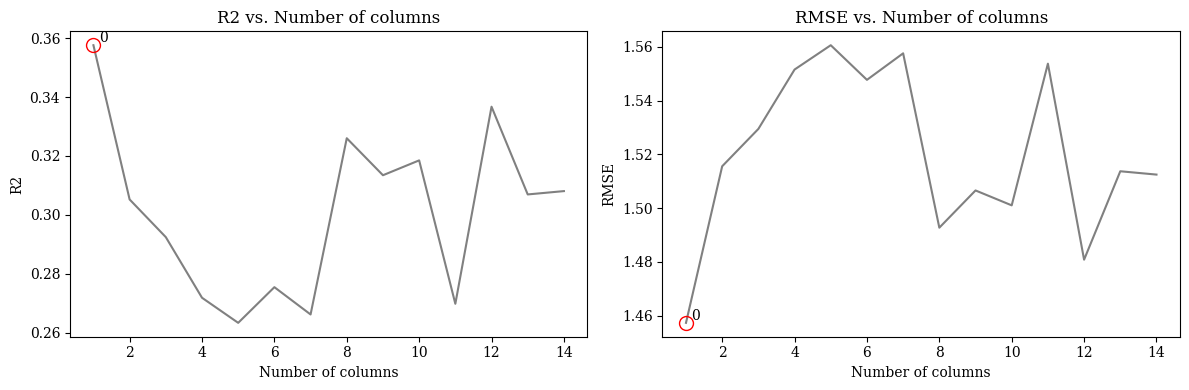

In [26]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the R2 values as a function of N in the first subplot
ax1.plot(range(1, N), r2_values,color='grey')
ax1.set_xlabel('Number of columns')
ax1.set_ylabel('R2')
ax1.set_title('R2 vs. Number of columns')

# Add a circle around the maximum R2 value
ax1.plot(range(1, N)[r2_idx], r2_values[r2_idx], 'o',color = 'red', markersize=10, fillstyle='none')
# Add the index of the maximum R2 value as a label
ax1.annotate(f'{r2_idx}', xy=(range(1, N)[r2_idx], r2_values[r2_idx]), xytext=(range(1, N)[r2_idx]+0.15, r2_values[r2_idx]+0.001))

# Plot the RMSE values as a function of N in the second subplot
ax2.plot(range(1, N), rmse_values,color='grey')
ax2.set_xlabel('Number of columns')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE vs. Number of columns')

# Add a circle around the minimum RMSE value
ax2.plot(range(1, N)[rmse_idx], rmse_values[rmse_idx], 'o',color = 'red', markersize=10, fillstyle='none')
# Add the index of the minimum RMSE value as a label
ax2.annotate(f'{rmse_idx}', xy=(range(1, N)[rmse_idx], rmse_values[rmse_idx]), xytext=(range(1, N)[rmse_idx]+0.15, rmse_values[rmse_idx]+0.001))

plt.tight_layout()
plt.show()